In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import silhouette_score
from tqdm import tqdm
# --- Configuration ---
# 1. Prediction Input: Window Size (number of frames to aggregate)
WINDOW_SIZE = 120  # e.g., 30 frames ~ 1 second (depending on FPS)

print("Configuration set.")


Configuration set.


***Training***

Step #1 read data

In [692]:
df = pd.read_csv('../ball-detector/game7_full_physics_tracking.csv')
data_path = '../ball-detector/game7_full_physics_tracking.csv'
labels = pd.read_csv('../ball-detector/labels.csv')

In [296]:
df.head()

,frame,class,conf,x1,y1,x2,y2,cx,cy,track_id,vx,vy,speed_px_frame,direction_deg
0,0,0,0.3540,1222,487,1240,507,1231.0,497.0,0,0.0,0.0,0.0,0.0
1,1,0,0.3313,1222,487,1240,507,1231.0,497.0,0,0.0,0.0,0.0,0.0
2,2,0,0.3337,1222,487,1240,505,1231.0,496.0,0,0.0,-1.0,1.0,-90.0
3,3,0,0.3296,1222,487,1240,505,1231.0,496.0,0,0.0,0.0,0.0,0.0
4,4,0,0.2043,1222,487,1240,505,1231.0,496.0,0,0.0,0.0,0.0,0.0


Step 2 clean data

In [2]:

def clean_noise(dfo):
    """
    Cleans volleyball tracking data by removing noise, resolving overlaps,
    and removing short tracks that interrupt longer, dominant trajectories.
    """
    df = dfo.copy()
    
    # 1. Calculate Global Track Statistics
    track_stats = df.groupby('track_id').agg(
        duration=('frame', 'count'),
        start_frame=('frame', 'min'),
        end_frame=('frame', 'max'),
        conf_mean=('conf', 'mean'),
        conf_max=('conf', 'max'),
        cx_range=('cx', lambda x: x.max() - x.min()),
        cy_range=('cy', lambda x: x.max() - x.min())
    )
    
    # Quality Score: Heavy weight on duration for volleyball trajectories
    track_stats['quality_score'] = track_stats['duration'] * track_stats['conf_mean']
    
    # 2. Filter obvious noise (Static or tiny tracks)
    track_stats['is_noise'] = (
        (track_stats[['cx_range', 'cy_range']].max(axis=1) < 30) |
        (track_stats['duration'] < 5) |
        ((track_stats['duration'] < 15) & (track_stats['conf_max'] < 0.5)) |
        (track_stats['conf_mean'] < 0.4) & (track_stats['duration'] > 20) |
        (track_stats[['cx_range', 'cy_range']].max(axis=1) < 100) & (track_stats['duration'] > 30)
    )
    
    # 3. Remove "Interrupter" Tracks
    # If Track B starts after Track A starts AND ends before Track A ends,
    # and Track A has a significantly higher quality score, Track B is likely noise.
    ids_to_remove = set(track_stats[track_stats['is_noise']].index)
    
    sorted_stats = track_stats.sort_values('quality_score', ascending=False)
    all_ids = sorted_stats.index.tolist()

    for i, dominant_id in enumerate(all_ids):
        if dominant_id in ids_to_remove:
            continue
            
        dom = sorted_stats.loc[dominant_id]
        
        for competitor_id in all_ids[i+1:]:
            if competitor_id in ids_to_remove:
                continue
                
            comp = sorted_stats.loc[competitor_id]
            
            # Check if competitor is "wrapped" inside the dominant track's timeframe
            is_contained = (comp['start_frame'] >= dom['start_frame']) and \
                           (comp['end_frame'] <= dom['end_frame'])
            
            if is_contained:
                ids_to_remove.add(competitor_id)

    df = df[~df['track_id'].isin(ids_to_remove)].copy()
    
    # 4. Resolve Overlaps (One detection per frame)
    df = df.merge(track_stats[['quality_score']], on='track_id', how='left')
    df = df.sort_values(by=['frame', 'quality_score'], ascending=[True, False])
    df_cleaned = df.drop_duplicates(subset=['frame'], keep='first')
    
    # 5. Final Continuity Check
    final_counts = df_cleaned['track_id'].value_counts()
    valid_tracks = final_counts[final_counts >= 3].index
    df_cleaned = df_cleaned[df_cleaned['track_id'].isin(valid_tracks)]
    
    df_cleaned = df_cleaned.sort_values('frame').drop(columns=['quality_score'])
    
    print(f"Cleanup complete. Remaining tracks: {df_cleaned['track_id'].nunique()}")
    return df_cleaned

In [724]:
clean_df= clean_noise(df)

Cleanup complete. Remaining tracks: 519


In [725]:
clean_df.head()

,frame,class,conf,x1,y1,x2,y2,cx,cy,track_id,vx,vy,speed_px_frame,direction_deg
0,2555,0,0.7295,153,676,178,705,165.5,690.5,94,0.0,0.0,0.000000,0.000000
1,2556,0,0.8496,147,673,178,703,162.5,688.0,94,-3.0,-2.5,3.905125,-140.194429
2,2557,0,0.8496,148,674,178,702,163.0,688.0,94,0.5,0.0,0.500000,0.000000
3,2558,0,0.8472,147,675,178,704,162.5,689.5,94,-0.5,1.5,1.581139,108.434949
4,2559,0,0.8535,147,675,179,705,163.0,690.0,94,0.5,0.5,0.707107,45.000000


Visaul Test of cleaning

In [444]:
def visualize_ball_tracking(video_path, cleaned_df, output_path="output_viz.mp4", limit=1000, start_frame=0):
    """
    Overlays tracking results on video starting from a specific frame.
    :param limit: Maximum number of frames to process from the start_frame.
    :param start_frame: The index of the frame where visualization begins.
    """
    cap = cv2.VideoCapture(video_path)
    
    # 1. Set the starting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # 2. Adjust frame range logic
    # The actual end frame is start_frame + limit, but cannot exceed total_frames
    end_frame = total_frames if limit is None else min(start_frame + limit, total_frames)
    frames_to_process = end_frame - start_frame

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Convert DF to dictionary for O(1) lookup
    ball_lookup = cleaned_df.set_index('frame').to_dict('index')
    
    trail = []

    # Progress bar should reflect the number of frames we are actually processing
    pbar = tqdm(total=frames_to_process, desc="Writing Video")

    while cap.isOpened():
        frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        
        # 3. Check if we have reached the end of our requested range
        if frame_idx >= end_frame:
            break

        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx in ball_lookup:
            data = ball_lookup[frame_idx]
            data['x']= (data['x1']+data['x2'])/2
            data['y']= (data['y1']+data['y2'])/2
            center = (int(data['x']), int(data['y']))
            trail.append(center)
            
            # Draw Bounding Box
            cv2.rectangle(frame, (int(data['x1']), int(data['y1'])), 
                          (int(data['x2']), int(data['y2'])), (0, 255, 0), 2)
            
            # Draw Confidence
            cv2.putText(frame, f"Conf: {data['conf']:.2f}", (int(data['x1']), int(data['y1'])-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Draw the trajectory trail
        if len(trail) > 1:
            for i in range(1, len(trail)):
                d = np.sqrt((trail[i][0]-trail[i-1][0])**2 + (trail[i][1]-trail[i-1][1])**2)
                if d < 400: 
                    cv2.line(frame, trail[i-1], trail[i], (255, 255, 0), 2)
        
        if len(trail) > 30:
            trail.pop(0)

        out.write(frame)
        pbar.update(1)

    pbar.close()
    cap.release()
    out.release()
    print(f"Visualization saved to {output_path} (Frames {start_frame} to {end_frame})")

In [445]:
visualize_ball_tracking(r"../videos/game1_set1.mp4", cleaned_df=clean_df, start_frame=2000, limit=1000)

Writing Video: 100%|██████████| 1000/1000 [00:16<00:00, 61.56it/s]

Visualization saved to output_viz.mp4 (Frames 2000 to 3000)


In [446]:
clean_df.head()

,frame,class,conf,x1,y1,x2,y2,cx,cy,track_id,vx,vy,speed_px_frame,direction_deg
0,65,0,0.3015,608,0,637,20,622.5,10.0,2,0.0,0.0,0.000000,0.000000
1,66,0,0.6943,633,0,673,28,653.0,14.0,2,30.5,4.0,30.761177,7.471559
2,67,0,0.8101,656,0,702,43,679.0,21.5,2,26.0,7.5,27.060118,16.090816
3,68,0,0.8291,682,11,726,50,704.0,30.5,2,25.0,9.0,26.570661,19.798876
4,69,0,0.8716,708,25,750,63,729.0,44.0,2,25.0,13.5,28.412145,28.369046


In [7]:
def interpolate_small_gaps(series, max_gap):
    # Find groups of NaNs
    isnull = series.isnull()
    # Create a unique ID for each contiguous block of NaNs
    gap_ids = (isnull != isnull.shift()).cumsum()
    # Count the size of each gap
    gap_sizes = gap_ids.map(gap_ids[isnull].value_counts())
    
    # Only interpolate where the gap size is <= our limit
    return series.interpolate(method='linear').where(gap_sizes <= max_gap, series)

In [9]:

def extract_features(dfo, window_size=120, start_frame=0,interpolation_size=5):
    """
    Extracts the specific feature set for model training.
    """
    df = dfo.copy()
    # 1. Timeline Expansion
    df = df.sort_values('frame').copy()
    full_range = pd.DataFrame({'frame': range(start_frame, int(df['frame'].max()) + 1)})
    df = pd.merge(full_range, df, on='frame', how='left')
    
    # Fill gaps for physics (visibility 'conf' stays 0 if not detected)
    df['cx'] = df['cx'].interpolate(method='linear', limit=interpolation_size)
    df['cy'] = df['cy'].interpolate(method='linear', limit=interpolation_size)
    df['conf'] = df['conf'].fillna(0)
    
    # 2. Physics Calculations
    df['vx'] = df['cx'].diff().fillna(0)
    df['vy'] = df['cy'].diff().fillna(0)
    df['velocity'] = np.sqrt(df['vx']**2 + df['vy']**2) 
    #if velocity bigger than 300 set it NAN
    df.loc[df['velocity'] > 200, 'velocity'] = np.nan
    df['acceleration'] = df['velocity'].diff().fillna(0)
    

    # Angular changes (Degrees)
    df['angle'] = np.degrees(np.arctan2(df['vy'], df['vx']))
    df['angle_diff'] = df['angle'].diff().abs()
    df['angle_diff'] = df['angle_diff'].apply(lambda x: min(x, 360-x) if not pd.isna(x) else 0)
    # 3. Rolling Window Features
    rolling = df.rolling(window=window_size, center=True, min_periods=1)
    
    # Map to requested names
    df['mean_x'] = rolling['cx'].mean()
    df['mean_y'] = rolling['cy'].mean()
    df['std_x'] = rolling['cx'].std().fillna(0)
    df['std_y'] = rolling['cy'].std().fillna(0)
    df['mean_vis'] = rolling['conf'].mean() # Visibility = Detection Confidence
    df['mean_velocity'] = rolling['velocity'].mean()
    df['max_velocity'] = rolling['velocity'].max()
    df['mean_acceleration'] = rolling['acceleration'].mean()
    df['mean_angle_change'] = rolling['angle_diff'].mean()
    
    # Kinetic Energy Proxy (v^2)
    df['energy'] = df['velocity']**2
    
    # Vertical range in window (Higher values = high arcs/sets)
    df['y_range_window'] = rolling['cy'].apply(lambda x: x.max() - x.min())
    
    # Cumulative distance (Total ball travel)
    df['total_dist'] = df['velocity'].cumsum()


    # Return selected columns
    return df

# usage
# df_cleaned = pd.read_csv('cleaned_volleyball_tracking.csv')
# model_df = extract_model_features(df_cleaned)

In [3]:
def extract_features(dfo, window_size=30, start_frame=0,interpolation_size=5):
    """
    Extracts features specifically tuned to classify 'Rally' vs 'Downtime'.
    Window_size defaults to 30 (approx 1 second at 30fps) to capture state.
    """
    df = dfo.copy()
    
    # 1. Timeline Expansion & Cleaning
    df = df.sort_values('frame')
    full_range = pd.DataFrame({'frame': range(start_frame, int(df['frame'].max()) + 1)})
    df = pd.merge(full_range, df, on='frame', how='left')
    
    # Fill gaps: limit to 3-5 frames to avoid creating "fake" physics for long disappearances
    df['cx'] = interpolate_small_gaps(df['cx'], max_gap=interpolation_size)
    df['cy'] = interpolate_small_gaps(df['cy'], max_gap=interpolation_size)

    df['conf'] = df['conf'].fillna(0)
    
    # 2. Basic Physics (Vectorized)
    df['vx'] = df['cx'].diff().fillna(0)
    df['vy'] = df['cy'].diff().fillna(0)
    df['velocity'] = np.sqrt(df['vx']**2 + df['vy']**2)
    
    # Clip outliers (ball moving > 300px/frame is usually a tracking jump)
    df['velocity'] = df['velocity'].clip(upper=300)
    df['acceleration'] = df['velocity'].diff().fillna(0)
    
    # Angular changes
    df['angle'] = np.degrees(np.arctan2(df['vy'], df['vx']))
    df['angle_diff'] = df['angle'].diff().abs() % 360
    df['angle_diff'] = np.minimum(df['angle_diff'], 360 - df['angle_diff']).fillna(0)

    # 3. Rally-Specific Engineered Features
    # Ratio of vertical to horizontal movement (High in rallies)
    df['y_dominance'] = np.abs(df['vy']) / (np.abs(df['vx']) + 1e-5)
    
    # Acceleration Jitter (Downtime often has erratic 'hand-held' movements)
    df['accel_jitter'] = df['acceleration'].diff().abs().fillna(0)
    
    # Kinetic Energy Proxy
    df['energy'] = df['velocity']**2
    
    # Is the ball in the bottom 20% of the screen? (Likely downtime)
    if not df['cy'].dropna().empty:
        floor_threshold = df['cy'].quantile(0.7)
        df['is_low'] = (df['cy'] > floor_threshold).astype(int)
    else:
        df['is_low'] = 0

    # 4. Rolling Window Features (The 'Context')
    rolling = df.rolling(window=window_size, center=True, min_periods=1)
    
    df['mean_x'] = rolling['cx'].mean()
    df['mean_y'] = rolling['cy'].mean()
    df['std_x'] = rolling['cx'].std().fillna(0)
    df['std_y'] = rolling['cy'].std().fillna(0)
    df['mean_velocity'] = rolling['velocity'].mean()
    df['max_velocity'] = rolling['velocity'].max()
    df['std_velocity'] = rolling['velocity'].std().fillna(0)
    df['mean_acceleration'] = rolling['acceleration'].mean()
    df['mean_angle_change'] = rolling['angle_diff'].mean()
    df['mean_y_dominance'] = rolling['y_dominance'].mean()
    df['mean_accel_jitter'] = rolling['accel_jitter'].mean()
    df['mean_energy'] = rolling['energy'].mean()
    # Vertical range is a huge indicator for rallies (high arcs)
    df['y_range_window'] = rolling['cy'].max() - rolling['cy'].min()
    
    # Visibility/Confidence consistency
    df['mean_vis'] = rolling['conf'].mean()
    df['vis_std'] = rolling['conf'].std().fillna(0)
    
    df['is_low_window'] = rolling['is_low'].mean()
    return df

In [500]:
features_df = extract_features(clean_df, window_size=WINDOW_SIZE)

In [409]:
features_df[100:200]

,frame,class,conf,x1,y1,x2,y2,cx,cy,track_id,...,std_x,std_y,mean_vis,mean_velocity,max_velocity,mean_acceleration,mean_angle_change,energy,y_range_window,total_dist
100,100,0.0,0.7593,991.0,366.0,1009.0,387.0,1000.0,376.5,2.0,...,123.384580,104.149980,0.491352,10.404831,30.886890,0.106667,7.031219,398.50,420.0,659.947909
101,101,0.0,0.3267,981.0,343.0,999.0,361.0,990.0,352.0,2.0,...,123.384546,103.711402,0.496827,10.511498,30.886890,0.106667,7.031219,700.25,420.0,686.410146
102,102,0.0,0.1128,974.0,330.0,996.0,351.0,985.0,340.5,2.0,...,123.360730,103.340238,0.502244,10.628592,30.886890,0.117094,7.063880,157.25,420.0,698.950082
103,103,0.0,0.7397,965.0,314.0,987.0,338.0,976.0,326.0,2.0,...,123.323277,103.069092,0.507495,10.755303,30.886890,0.126711,7.086491,291.25,420.0,716.016130
104,104,0.0,0.7876,957.0,298.0,979.0,322.0,968.0,310.0,2.0,...,123.281526,102.920959,0.511153,10.878681,30.886890,0.123378,7.106861,320.00,420.0,733.904674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,0.0,0.8232,400.0,267.0,446.0,311.0,423.0,289.0,2.0,...,414.040262,257.426538,0.529331,20.244167,129.541499,0.183259,9.548286,794.00,933.5,1950.647785
196,196,0.0,0.8184,373.0,284.0,422.0,330.0,397.5,307.0,2.0,...,415.602438,257.341601,0.529210,20.420772,129.541499,0.176605,9.485867,974.25,933.5,1981.860763
197,197,0.0,0.8164,346.0,305.0,394.0,348.0,370.0,326.5,2.0,...,416.855485,257.253603,0.528513,20.608325,129.541499,0.187553,9.497390,1136.50,933.5,2015.572778
198,198,0.0,0.7993,314.0,330.0,368.0,379.0,341.0,354.5,2.0,...,417.865634,257.196308,0.528149,20.772261,129.541499,0.163935,9.563191,1625.00,933.5,2055.884067


In [306]:
from fastai.imports import *

In [501]:
features_df = features_df.fillna(0)

In [502]:
features_df

,frame,class,conf,x1,y1,x2,y2,cx,cy,track_id,vx,vy,speed_px_frame,direction_deg,velocity,acceleration,angle,angle_diff,y_dominance,accel_jitter,energy,is_low,mean_x,mean_y,std_x,std_y,mean_velocity,max_velocity,std_velocity,mean_acceleration,mean_angle_change,mean_y_dominance,mean_accel_jitter,mean_energy,y_range_window,mean_vis,vis_std,is_low_window
0,0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,1,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,2,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,3,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,4,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37072,37072,0.0,0.7578,1827.0,573.0,1862.0,603.0,1844.5,588.0,1031.0,19.5,9.5,21.691012,25.974394,21.691012,4.588381,25.974394,10.719275,0.487179,2.782808,470.50,1,1275.250000,592.830769,443.121986,28.439358,36.466267,300.000000,48.955406,-0.653410,10.785658,0.400704,25.677468,3689.549145,112.5,0.684480,0.254919,0.646154
37073,37073,0.0,0.7769,1843.0,577.0,1870.0,604.0,1856.5,590.5,1031.0,12.0,2.5,12.257651,11.768289,12.257651,-9.433361,11.768289,14.206105,0.208333,14.021742,150.25,1,1277.660156,592.820312,446.195367,28.664053,36.129114,300.000000,49.266293,-0.663619,10.954184,0.371974,26.078678,3694.555990,112.5,0.689572,0.253580,0.640625
37074,37074,0.0,0.7954,1860.0,586.0,1895.0,613.0,1877.5,599.5,1031.0,21.0,9.0,22.847319,23.198591,22.847319,10.589669,23.198591,11.430302,0.428571,20.023030,522.00,1,1280.162698,592.809524,449.326341,28.894159,36.686719,300.000000,49.458017,0.231308,10.081436,0.377878,25.587165,3753.183862,112.5,0.694697,0.252254,0.634921
37075,37075,0.0,0.7217,1875.0,597.0,1911.0,629.0,1893.0,613.0,1031.0,15.5,13.5,20.554805,41.054814,20.554805,-2.292515,41.054814,17.856223,0.870967,12.882183,422.50,1,1289.237903,592.366935,447.135553,28.913938,32.439731,300.000000,36.486185,-4.587542,10.182713,0.382901,20.257215,2362.106183,112.5,0.705902,0.237983,0.629032


In [470]:
labels.head()

,label
0,Downtime
1,Downtime
2,Downtime
3,Downtime
4,Downtime


In [503]:
#add labels to features_df
features_df['label'] = labels['label']

In [504]:

features_df['label'] = pd.Categorical(features_df.label)

In [476]:
pd.set_option('display.max_columns', None)

In [477]:
features_df

,frame,class,conf,x1,y1,x2,y2,cx,cy,track_id,vx,vy,speed_px_frame,direction_deg,velocity,acceleration,angle,angle_diff,y_dominance,accel_jitter,energy,mean_velocity,max_velocity,std_velocity,mean_acceleration,mean_angle_change,y_range_window,mean_vis,vis_std,total_dist,is_low,label
0,0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,Downtime
1,1,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,Downtime
2,2,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,Downtime
3,3,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,Downtime
4,4,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,Downtime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37072,37072,0.0,0.7578,1827.0,573.0,1862.0,603.0,1844.5,588.0,1031.0,19.5,9.5,21.691012,25.974394,21.691012,4.588381,25.974394,10.719275,0.487179,2.782808,470.50,36.466267,300.000000,48.955406,-0.653410,10.785658,112.5,0.684480,0.254919,356480.233623,1,Downtime
37073,37073,0.0,0.7769,1843.0,577.0,1870.0,604.0,1856.5,590.5,1031.0,12.0,2.5,12.257651,11.768289,12.257651,-9.433361,11.768289,14.206105,0.208333,14.021742,150.25,36.129114,300.000000,49.266293,-0.663619,10.954184,112.5,0.689572,0.253580,356492.491274,1,Downtime
37074,37074,0.0,0.7954,1860.0,586.0,1895.0,613.0,1877.5,599.5,1031.0,21.0,9.0,22.847319,23.198591,22.847319,10.589669,23.198591,11.430302,0.428571,20.023030,522.00,36.686719,300.000000,49.458017,0.231308,10.081436,112.5,0.694697,0.252254,356515.338593,1,Downtime
37075,37075,0.0,0.7217,1875.0,597.0,1911.0,629.0,1893.0,613.0,1031.0,15.5,13.5,20.554805,41.054814,20.554805,-2.292515,41.054814,17.856223,0.870967,12.882183,422.50,32.439731,300.000000,36.486185,-4.587542,10.182713,112.5,0.705902,0.237983,356535.893398,1,Downtime


In [455]:
conts=['mean_x', 'mean_y', 'std_x', 'std_y', 'mean_vis', 'mean_velocity', 'max_velocity', 'mean_acceleration','mean_angle_change','energy','y_range_window','total_dist',]
dep="label"

In [505]:
conts = ['mean_x', 'mean_y', 'std_x', 'std_y', 'mean_velocity', 'max_velocity', 'std_velocity',
             'mean_acceleration', 'mean_angle_change', 'mean_y_dominance', 'mean_accel_jitter', 'mean_energy', 'y_range_window', 'mean_vis', 'vis_std', 'is_low_window']
dep="label"

In [519]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(28)
# 1. Ensure they are independent copies
trn_df, val_df = train_test_split(features_df, test_size=0.25,shuffle=False)
trn_df = trn_df.copy()
val_df = val_df.copy()

# 2. Convert to categorical and extract codes in one step
trn_df[dep] = pd.Categorical(trn_df[dep]).codes
val_df[dep] = pd.Categorical(val_df[dep]).codes

In [520]:
#print number of rows
print("Training set rows:", len(trn_df))
print("Validation set rows:", len(val_df))

Training set rows: 27807
Validation set rows: 9270


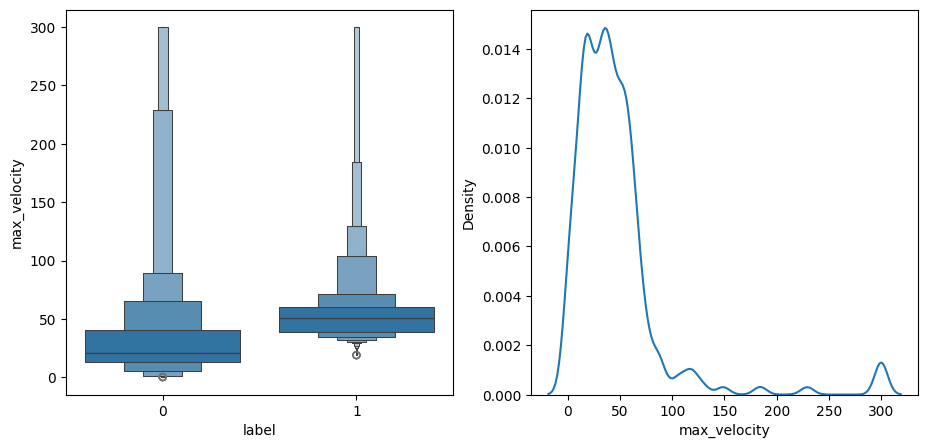

In [521]:
import seaborn as sns
df_meanVis = trn_df[(trn_df.max_velocity>0)]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_meanVis, x=dep, y="max_velocity", ax=axs[0])
sns.kdeplot(data=df_meanVis, x="max_velocity", ax=axs[1]); 

In [522]:
def xs_y(df):
    xs = df[conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [523]:
from sklearn.ensemble import RandomForestClassifier

rf_phy = RandomForestClassifier(200, min_samples_leaf=10)
rf_phy.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf_phy.predict(val_xs))

0.06947141316073355

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib


In [524]:
from sklearn.metrics import accuracy_score
print(accuracy_score(val_y, rf_phy.predict(val_xs)))

0.9305285868392664


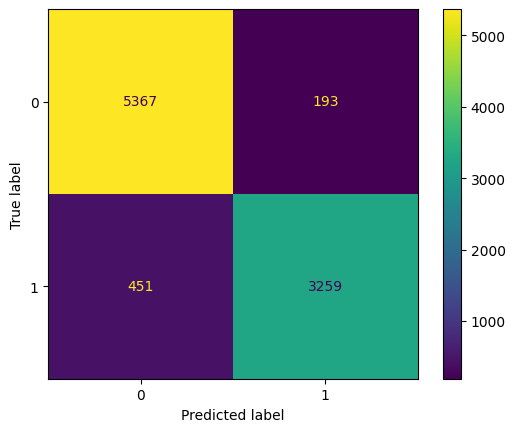

In [525]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf_phy, val_xs, val_y)

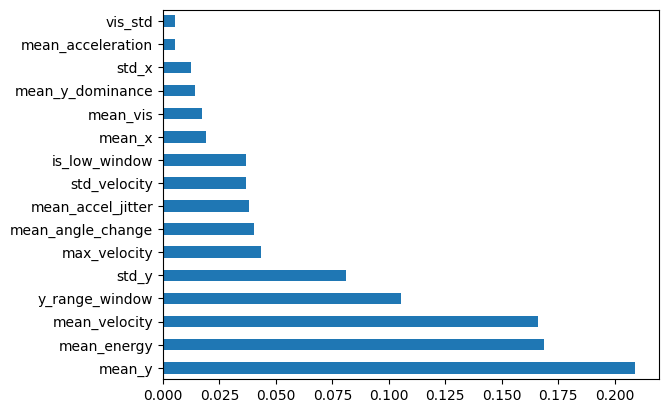

In [526]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a series with feature names and their importance scores
feat_importances = pd.Series(rf_phy.feature_importances_, index=trn_xs.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [647]:
import joblib

# Save the model
joblib.dump(rf_phy, 'my_random_forest_phy_2.pkl')

['my_random_forest_phy_2.pkl']

In [ ]:
loaded_rf = joblib.load('my_random_forest_phy_1.pkl')

In [5]:
def train_random_forest(df_path,labels_path,window_size=120,interpolation_size=10,num_est=100,num_min_samples=20):
    df = pd.read_csv(df_path)
    labels = pd.read_csv(labels_path)
    clean_df= clean_noise(df)
    features_df = extract_features(clean_df, window_size=window_size,interpolation_size=interpolation_size)
    features_df['label'] = labels['label']
    features_df = features_df.fillna(0)

    conts = ['mean_x', 'mean_y', 'std_x', 'std_y', 'mean_velocity', 'max_velocity', 'std_velocity',
             'mean_acceleration', 'mean_angle_change', 'mean_y_dominance', 'mean_accel_jitter', 'mean_energy', 'y_range_window', 'mean_vis', 'vis_std', 'is_low_window']
    dep="label"

    trn_df, val_df = train_test_split(features_df, test_size=0.25,shuffle=False)
    trn_df = trn_df.copy()
    val_df = val_df.copy()

    trn_df[dep] = pd.Categorical(trn_df[dep]).codes
    val_df[dep] = pd.Categorical(val_df[dep]).codes
    
    def xs_y(df):
        xs = df[conts].copy()
        return xs,df[dep] if dep in df else None

    trn_xs,trn_y = xs_y(trn_df)
    val_xs,val_y = xs_y(val_df)

    rf_phy = RandomForestClassifier(num_est, min_samples_leaf=num_min_samples)
    rf_phy.fit(trn_xs, trn_y);
    print("Validation MAE:", mean_absolute_error(val_y, rf_phy.predict(val_xs)))
    print("Validation Accuracy:", accuracy_score(val_y, rf_phy.predict(val_xs)))
    return rf_phy

    

In [9]:
data_path = "C:\\Users\\morde\\Desktop\\projects\\test vb cv\\my_code\\ball_detector\\game1_set1_physics_tracking.csv"
labels_path = "C:\\Users\\morde\\Desktop\\projects\\test vb cv\\my_code\\ball_detector\\labels.csv"
rf = train_random_forest(data_path, labels_path, window_size=120, interpolation_size=5)

Cleanup complete. Remaining tracks: 159
Validation MAE: 0.07378640776699029
Validation Accuracy: 0.9262135922330097


In [21]:
data_path = "C:\\Users\\morde\\Desktop\\projects\\test vb cv\\my_code\\ball_detector\\game1_set1_physics_tracking.csv"
labels_path = "C:\\Users\\morde\\Desktop\\projects\\test vb cv\\my_code\\ball_detector\\labels.csv"
rf = train_random_forest(data_path, labels_path, window_size=60, interpolation_size=5)

Cleanup complete. Remaining tracks: 159
Validation MAE: 0.04735706580366775
Validation Accuracy: 0.9526429341963323


In [10]:
# Save the model
joblib.dump(rf, 'rally_predictor_rf_2.pkl')

['rally_predictor_rf_2.pkl']

In [603]:
def predict_rallies(rf_model, df_path, window_size=120, interpolation_size=10):
    df = pd.read_csv(df_path)
    clean_df= clean_noise(df)
    features_df = extract_features(clean_df, window_size=window_size,interpolation_size=interpolation_size)
    features_df = features_df.fillna(0)
    conts = ['mean_x', 'mean_y', 'std_x', 'std_y', 'mean_velocity', 'max_velocity', 'std_velocity',
             'mean_acceleration', 'mean_angle_change', 'mean_y_dominance', 'mean_accel_jitter', 'mean_energy', 'y_range_window', 'mean_vis', 'vis_std', 'is_low_window']
    predictions = rf_model.predict(features_df[conts])
    return predictions

In [736]:
data_path = '../ball-detector/game7_full_physics_tracking.csv'
predictions = predict_rallies(rf, data_path, window_size=90, interpolation_size=30)

Cleanup complete. Remaining tracks: 530


In [683]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [605]:
import pandas as pd
import numpy as np

def analyze_rally_stats(predictions, fps=30):
    # Convert to Series for easier manipulation
    s = pd.Series(predictions)
    
    # Identify groups of consecutive identical values
    # (e.g., [0,0,1,1,1,0] becomes [1,1,2,2,2,3])
    groups = (s != s.shift()).cumsum()
    
    # Create a DataFrame of segments
    segments = s.groupby(groups).agg(
        label='first',
        frame_count='count'
    )
    
    # Calculate duration in seconds
    segments['duration_sec'] = segments['frame_count'] / fps
    
    # Filter for Rallies and Downtime
    rallies = segments[segments['label'] == 1]['duration_sec']
    downtime = segments[segments['label'] == 0]['duration_sec']
    
    stats = {
        "Total Rallies": len(rallies),
        "Shortest Rally (s)": rallies.min() if not rallies.empty else 0,
        "Longest Rally (s)": rallies.max() if not rallies.empty else 0,
        "Average Rally (s)": rallies.mean() if not rallies.empty else 0,
        "Shortest Downtime (s)": downtime.min() if not downtime.empty else 0,
        "Total Playtime (s)": rallies.sum()
    }
    
    return stats, segments

In [737]:
stats, segments = analyze_rally_stats(predictions=predictions, fps=30)

In [738]:
stats

{'Total Rallies': 451,
 'Shortest Rally (s)': 0.03333333333333333,
 'Longest Rally (s)': 39.46666666666667,
 'Average Rally (s)': 3.3099778270509983,
 'Shortest Downtime (s)': 0.03333333333333333,
 'Total Playtime (s)': 1492.8000000000002}

In [686]:
segments[0:30] 

,label,frame_count,duration_sec
1,0,6429,214.300000
2,1,162,5.400000
3,0,692,23.066667
4,1,104,3.466667
5,0,36,1.200000
6,1,3,0.100000
7,0,1,0.033333
8,1,544,18.133333
9,0,51,1.700000
10,1,1,0.033333


In [687]:
def smooth_predictions(predictions, window_size=5, min_segment_len=60):
    if len(predictions) == 0:
        return predictions

    # 1. Apply rolling mode filter
    # center=True ensures the window is balanced around the current frame
    series = pd.Series(predictions)
    smoothed = series.rolling(window=window_size, center=True).apply(
        lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[len(x)//2]
    ).fillna(series) # Fill NaNs at edges with original values
    
    smoothed_list = smoothed.tolist()

    # 2. Merge small segments
    # We loop until no more small segments are found to handle 
    # cases where merging creates a new small segment
    changed = True
    while changed:
        changed = False
        i = 0
        while i < len(smoothed_list):
            start = i
            val = smoothed_list[i]
            
            # Find the end of the current segment
            while i < len(smoothed_list) and smoothed_list[i] == val:
                i += 1
            segment_len = i - start
            
            # If segment is too short, merge it
            if segment_len < min_segment_len:
                # Determine the replacement value
                # Prefer the neighbor that exists; if both exist, 
                # you could pick the longer one or just the previous one.
                prev_val = smoothed_list[start - 1] if start > 0 else None
                next_val = smoothed_list[i] if i < len(smoothed_list) else None
                
                new_val = prev_val if prev_val is not None else next_val
                
                if new_val is not None and new_val != val:
                    smoothed_list[start:i] = [new_val] * segment_len
                    changed = True
                    
    return smoothed_list


In [739]:
s_predictions = smooth_predictions(predictions, window_size=5, min_segment_len=60)

In [741]:
stats, segments = analyze_rally_stats(predictions=s_predictions, fps=30)

In [742]:
stats

{'Total Rallies': 129,
 'Shortest Rally (s)': 2.1666666666666665,
 'Longest Rally (s)': 48.833333333333336,
 'Average Rally (s)': 11.627906976744185,
 'Shortest Downtime (s)': 2.2,
 'Total Playtime (s)': 1500.0}

In [644]:
segments[0:20]

,label,frame_count,duration_sec
1,1.0,231,7.700000
2,0.0,475,15.833333
3,1.0,277,9.233333
4,0.0,466,15.533333
5,1.0,490,16.333333
6,0.0,470,15.666667
7,1.0,450,15.000000
8,0.0,411,13.700000
9,1.0,256,8.533333
10,0.0,435,14.500000


In [743]:
pd.DataFrame({'s_predictions': s_predictions}).to_csv('s_predictions_game7_full.csv', index=False)